# Rendezvous Trajectories

In [507]:
#!/usr/bin/env python3

import pyomo.environ as pyo
import numpy as np
import matplotlib.pyplot as plt
from utils.orbital_elements import *

In [540]:
# MPC Hyper Parameters
class TrajectoryParams():
    # Main Params
    dt = 200 # [sec] MPC sampling time
    N = 50
    
    # Objective Params:
    R = 100*np.diag([1.0, 1.0, 1.0])
    Q = np.diag([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
    Qf = 100*np.diag([2.0, 2.0, 1.0, 100.0])

class TrajectorySolver():
    def __init__(self, params=TrajectoryParams(), plot=False):
        # Store main parameters
        self.dt = params.dt # [sec] MPC sampling time
        self.N = params.N # Number of samples
        self.plot = plot # Generate a plot each __call__?
        # Store objective parameters
        self.obj = self._cvx_obj # Specify which obj to use
        self.Q = params.Q # State path weight matrix
        self.R = params.R # Input path weight matrix
        self.Qf = params.Qf # State terminal weight matrix

        # Initialize model and solver
        self.opt = pyo.SolverFactory('ipopt') # Optimizer
        self.model = self._init_model()

    # Solve the MPC problem with initial state x0 and desired xf
    # returns u0 (v_dot, psi_dot)
    def __call__(self,*, x0, xf, u_max=10.0, tee=False):
        # Initialize parameters
        self.model.x0[0] = x0[0]
        self.model.x0[1] = x0[1]
        self.model.x0[2] = x0[2]
        self.model.x0[3] = x0[3]
        self.model.x0[4] = x0[4]
        self.model.x0[5] = x0[5]
        
        self.model.xf[0] = xf[0]
        self.model.xf[1] = xf[1]
        self.model.xf[2] = xf[2]
        self.model.xf[3] = xf[3]
        self.model.xf[4] = xf[4]
        self.model.xf[5] = xf[5]
        
        self.model.u_max[0] = u_max
        # Solve problem
        self.opt.solve(self.model, tee=tee)

        # Retrieve input u0
        xs = np.array([self.model.state[t,0].value for t in range(self.N)])
        ys = np.array([self.model.state[t,1].value for t in range(self.N)])
        zs = np.array([self.model.state[t,2].value for t in range(self.N)])
        
        vxs = np.array([self.model.state[t,3].value for t in range(self.N)])
        vys = np.array([self.model.state[t,4].value for t in range(self.N)])
        vzs = np.array([self.model.state[t,5].value for t in range(self.N)])
        
        uxs = np.array([self.model.input[t,0].value for t in range(self.N)])
        uys = np.array([self.model.input[t,1].value for t in range(self.N)])
        uzs = np.array([self.model.input[t,2].value for t in range(self.N)])
        times = np.linspace(0, self.N*self.dt, self.N)
        
        output = np.vstack([times, xs, ys, zs, vxs, vys, vzs]).T

        # Plot
        if self.plot:
            self._plot()

        return output


    # Interval constraints on u
    def _input_bounds(self, model, t, i):
        return(-1*model.u_max[0], model.u_max[0])
        # return (None, None)

    # Interval constraints on x
    def _state_bounds(self, model, t, i):
        if i == 0: # x
            return(None, None)
        elif i == 1: # y
            return(None, None)
        elif i == 2: # z
            return(None, None)
        elif i == 3: # vx
            return(None, None)
        elif i == 4: # vy
            return(None, None)
        else: # vz
            return(None, None)

#     # Nonconvex Objective
#     def _ncvx_obj(self, model):
#         term_expr = self.Qf[0][0]*(model.state[self.N,0] - model.xf[0])**2 + \
#                 self.Qf[1][1]*(model.state[self.N,1] - model.xf[1])**2 + \
#                 self.Qf[2][2]*(model.state[self.N,2] - model.xf[2])**2 + \
#                 self.Qf[3][3]*(model.state[self.N,3] - model.xf[3])**2
#         accsum_expr = sum([dv**2 for dv in model.input[:,0]])
#         angsum_expr = 0.0
#         for k in range(self.N):
#             angsum_expr += (model.state[k,2]**4)*\
#                     (pyo.tan(model.input[k,1])**2)/(self.L**2)

#         # Add all costs
#         obj = pyo.Objective(expr = term_expr + accsum_expr + angsum_expr)

#         return obj

    # Convex Objective
    def _cvx_obj(self, model):
        mul = 0.0
        obj = pyo.Objective(expr = sum([sum([model.input[i,j]**2 for i in range(self.N)]) for j in range(3)]))
        # obj = pyo.Objective(expr = sum([model.firing[i]**2 for i in range(self.N)]))
        return obj

    # Create and initialize Pyomo model
    def _init_model(self):
        mu = 3.986e14
        rc = 8000e3
        n = np.sqrt(mu / (rc**3))
        model = pyo.ConcreteModel()
        model.limits = pyo.ConstraintList()
        
        model.u_max = pyo.Param([0], within=pyo.Reals, mutable=True, default=0.1)
        
        # Optimization parameters
        model.x0 = pyo.Param(range(6), within=pyo.Reals, mutable=True, default=0.0)
        model.xf = pyo.Param(range(6), within=pyo.Reals, mutable=True, default=0.0)

        # Optimization variables
        model.state = pyo.Var(range(self.N+1), range(6),
                domain=pyo.Reals, bounds=self._state_bounds)

        model.input = pyo.Var(range(self.N), range(3),
                domain=pyo.Reals, bounds=self._input_bounds, initialize=1e-8)
        model.firing = pyo.Var(range(self.N), domain=pyo.Binary, initialize=1)
        # model.firing = pyo.Param(range(self.N), domain=pyo.Reals, default=1.0)
        
        # Firing constraints
        for n in range(self.N):
            model.limits.add(10*model.firing[n] >= model.input[n,1])
            model.limits.add(10*model.firing[n] >= -1*model.input[n,1])
            # model.limits.add(model.input[n, 0]**2 <= model.firing[n])
            # model.limits.add(model.input[n, 1]**2 <= 1e14*model.firing[n])
            # model.limits.add(model.input[n, 2]**2 <= model.firing[n])

        # Initial conditions
        model.limits.add(model.state[0,0] == model.x0[0])
        model.limits.add(model.state[0,1] == model.x0[1])
        model.limits.add(model.state[0,2] == model.x0[2])
        model.limits.add(model.state[0,3] == model.x0[3])
        model.limits.add(model.state[0,4] == model.x0[4])
        model.limits.add(model.state[0,5] == model.x0[5])
        
        # # Final conditions
        model.limits.add(model.state[self.N,0] == model.xf[0])
        model.limits.add(model.state[self.N,1] == model.xf[1])
        model.limits.add(model.state[self.N,2] == model.xf[2])
        model.limits.add(model.state[self.N,3] == model.xf[3])
        model.limits.add(model.state[self.N,4] == model.xf[4])
        model.limits.add(model.state[self.N,5] == model.xf[5])

        # Dynamics Constraints
        for k in range(self.N):
            # X position
            model.limits.add(model.state[k+1,0] == model.state[k,0] + self.dt*model.state[k,3])
            # Y Position
            model.limits.add(model.state[k+1,1] == model.state[k,1] + self.dt*model.state[k,4])
            # Z Position
            model.limits.add(model.state[k+1,2] == model.state[k,2] + self.dt*model.state[k,5])
            
            denom = pyo.sqrt((rc+model.state[k,0])*(rc+model.state[k,0]) + model.state[k,1]*model.state[k,1] + model.state[k,2]*model.state[k,2])**3
            # X Velocity
            model.limits.add(model.state[k+1,3] == model.state[k,3] + self.dt*(-1*mu*(rc + model.state[k,0])/denom + mu/rc**2 + 2*n*model.state[k,4] + n*n*model.state[k,0] + model.input[k, 0]))
            
            # Y Velocity
            model.limits.add(model.state[k+1,4] == model.state[k,4] + self.dt*(-1*mu*model.state[k,1]/denom + 2*n*model.state[k,3] + n*n*model.state[k,1] + model.input[k, 1]))
            
            # Z Velocity
            model.limits.add(model.state[k+1,5] == model.state[k,5] + self.dt*(-1*mu*model.state[k,2]/denom + model.input[k, 2]))
            
#             # X position
#             model.limits.add(model.state[k+1,0] == model.state[k,0] + self.dt*model.state[k,3])
#             # Y Position
#             model.limits.add(model.state[k+1,1] == model.state[k,1] + self.dt*model.state[k,4])
#             # Z Position
#             model.limits.add(model.state[k+1,2] == model.state[k,2] + self.dt*model.state[k,5])
#             bj
#             # X Velocity
#             model.limits.add(model.state[k+1,3] == model.state[k,3] + self.dt*(model.input[k, 0] + 3*n*n*model.state[k,0] + 2*n*model.state[k,4]))
            
#             # Y Velocity
#             model.limits.add(model.state[k+1,4] == model.state[k,4] + self.dt*(model.input[k, 1] + -2*n*model.state[k,3]))
            
#             # Z Velocity
#             model.limits.add(model.state[k+1,5] == model.state[k,5] + self.dt*(model.input[k, 2] + -1*n*n*model.state[k,2]))
            

        # Get obj function
        model.OBJ = self.obj(model)

        # Return model
        return model


    # Create 'mpc_traj.png'
    def _plot(self):
        xs = np.array([self.model.state[t,0].value for t in range(self.N)])
        ys = np.array([self.model.state[t,1].value for t in range(self.N)])
        zs = np.array([self.model.state[t,2].value for t in range(self.N)])
        
        uxs = np.array([self.model.input[t,0].value for t in range(self.N)])
        uys = np.array([self.model.input[t,1].value for t in range(self.N)])
        uzs = np.array([self.model.input[t,2].value for t in range(self.N)])
        
        firing = np.array([self.model.firing[t].value for t in range(self.N)])
        
        times = np.linspace(0, self.N*self.dt, self.N)
        
        plt.plot(xs, ys)
        plt.title("Trajectory (In RT plane)")
        plt.show()
        plt.plot(times, uxs)
        plt.plot(times, uys)
        plt.plot(times, uzs)
        plt.legend(["R", "T", "N"])
        plt.title("Control (m/s^2)")
        plt.show()
        plt.plot(times, xs)
        plt.plot(times, ys)
        plt.legend(["R (m)", "T (m)"])
        axes_equal = False
        plt.show()
        plt.plot(firing)
        plt.title("Firing")
        plt.show()

Ipopt 3.14.5: 
==> Warning: Treating 50 binary and 0 integer variables as continuous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.5, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     1462
Number of nonzeros in inequality constraint Jacobian.:      200
Number of nonzeros in Lagrangian Hessian.............:      450

Total number of variables............................:      506
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      200
                     variables with only upper bounds:        0
Total 

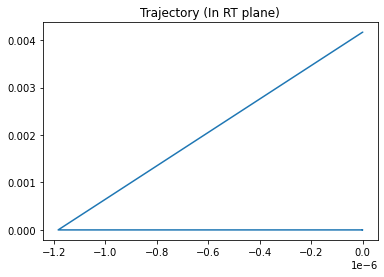

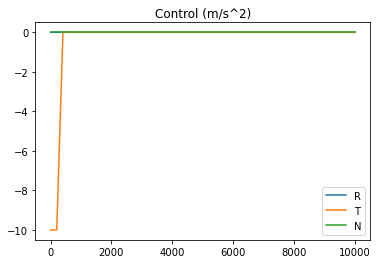

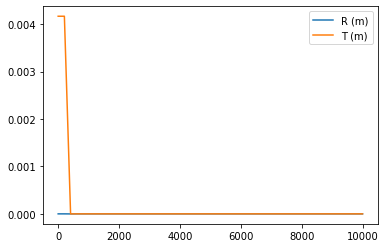

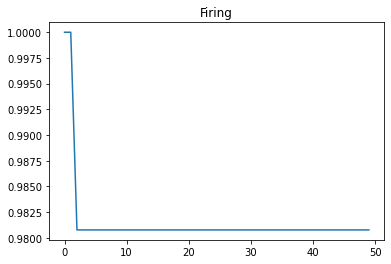

In [541]:
solver = TrajectorySolver(plot=True)

targetPV = pv_from_moe(moe=make_coe(a=8000e3,arg_peri=0.0,e=0.0,i=0.0,raan=0.0,true_anom=0.0))
chaserPV = pv_from_moe(moe=make_coe(a=8000e3,arg_peri=0.0,e=0.0,i=0.0,raan=0.0,true_anom=(0.001/4.0)))
output = solver(x0=[0, 2000, 0, 0.0, 0, 0], xf=[0, 0, 0, 0, 0, 0],u_max=1e8, tee=True)

In [542]:
np.savetxt("2000mLeadingRendezvous.csv", output, delimiter=",", header="time,x,y,z,vx,vy,vz", comments="")

In [526]:
print(output[0,:])

[   0.    0. 2000.    0.    0.    0.    0.]
